In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras.backend as KerasBackend
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import keras_tuner
SEED =1
import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
X_train_df = pd.DataFrame({'year': train_df['date'].dt.year-2013,'month':train_df['date'].dt.month,'day': train_df['date'].dt.day,
                        'weekday':train_df['date'].dt.weekday,'store':train_df['store'],'item':train_df['item']})
X_train = np.array(X_train_df)
X_test_df = pd.DataFrame({'year': test_df['date'].dt.year-2013,'month':test_df['date'].dt.month,'day': test_df['date'].dt.day,
                       'weekday':test_df['date'].dt.weekday,'store':test_df['store'],'item':test_df['item']})
X_test = np.array(X_test_df)

In [4]:
Y_train = np.array(train_df['sales'])
id_test = np.array(test_df['id'])

In [5]:
print(X_train.shape, Y_train.shape) 
print(X_test.shape, id_test.shape)

(913000, 6) (913000,)
(45000, 6) (45000,)


In [6]:
X_train

array([[ 0,  1,  1,  1,  1,  1],
       [ 0,  1,  2,  2,  1,  1],
       [ 0,  1,  3,  3,  1,  1],
       ...,
       [ 4, 12, 29,  4, 10, 50],
       [ 4, 12, 30,  5, 10, 50],
       [ 4, 12, 31,  6, 10, 50]], dtype=int64)

In [7]:
X_comb = pd.concat([X_train_df, X_test_df])

print("Years: "+str(X_comb['year'].nunique()))
print("Month: "+ str(X_comb['month'].nunique()))
print("Day: "+ str(X_comb['day'].nunique()))
print("Weekday: "+ str(X_comb['weekday'].nunique()))
print("Store: "+ str(X_comb['store'].nunique()))
print("Item: "+ str(X_comb['item'].nunique()))

unique={'year':X_comb['year'].nunique(),'month': X_comb['month'].nunique(), 'day':X_comb['day'].nunique(), 
        'weekday':X_comb['weekday'].nunique(), 'store':X_comb['store'].nunique(), 'item': X_comb['item'].nunique()}

Years: 6
Month: 12
Day: 31
Weekday: 7
Store: 10
Item: 50


In [8]:
X_train_ds, X_valid_ds, Y_train_ds, Y_valid_ds = train_test_split(X_train, Y_train, test_size=0.1, random_state=0, shuffle = True)
print(X_train_ds.shape, Y_train_ds.shape)
print(X_valid_ds.shape, Y_valid_ds.shape)

(821700, 6) (821700,)
(91300, 6) (91300,)


In [9]:
def smape(x, y):
    x, y = float(x), float(y)
    return 100.*KerasBackend.mean(2*KerasBackend.abs(x-y)/(KerasBackend.abs(x)+KerasBackend.abs(y)))

In [10]:
def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = KerasBackend.sum(KerasBackend.square( y_true - y_pred )) 
    SS_tot = KerasBackend.sum(KerasBackend.square( y_true - KerasBackend.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + KerasBackend.epsilon()) )

In [11]:
def build_model(hp):
    year = keras.Input(shape=(1,), name="year", dtype="float32")
    month = keras.Input(shape=(1,), name="month", dtype="int64")
    day = keras.Input(shape=(1,), name="day", dtype="int64")
    weekday = keras.Input(shape=(1,), name="weekday", dtype="int64")
    store = keras.Input(shape=(1,), name="store", dtype="int64")
    item = keras.Input(shape=(1,), name="item", dtype="int64")

    all_inputs = [
        year,
        month,
        day,
        weekday,
        store,
        item
    ]

    m = layers.Embedding(unique['month']+1, (unique['month']//2)+1)(month)
    outputm = layers.Flatten()(m)
    d = layers.Embedding(unique['day']+1, (unique['day']//2)+1)(day)
    outputd = layers.Flatten()(d)
    wd = layers.Embedding(unique['weekday']+1, (unique['weekday']//2)+1)(weekday)
    outputwd = layers.Flatten()(wd)
    s = layers.Embedding(unique['store']+1, (unique['store']//2)+1)(store)
    outputs = layers.Flatten()(s)
    i = layers.Embedding(unique['item']+1, (unique['item']//2)+1)(item)
    outputi = layers.Flatten()(i)

    all_features = layers.concatenate([
        year,
        outputm,
        outputd,
        outputwd,
        outputs,
        outputi,
    ])
    x = layers.Dense(hp.Int('Number of Neurons', 128, 512, step=64), activation="relu")(all_features)
    x = layers.Dense(hp.Int('Number of Neurons', 128, 512, step=64), activation="relu")(x)
    x = layers.Dense(hp.Int('Number of Neurons', 128, 512, step=64), activation="relu")(x)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-5, 2e-1, sampling='log')), 
                  loss=smape, 
                  metrics=[r2, tf.keras.metrics.RootMeanSquaredError(name="rmse")])
            
    return model

In [12]:
# Defining the tuner and using bayesian optimization
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective='val_loss',
    overwrite=True,
    max_trials=7)

In [13]:
# Using the tuner to search for the best hyperparameters
tuner.search(
    [X_train_ds[:,0],X_train_ds[:,1],X_train_ds[:,2],X_train_ds[:,3],X_train_ds[:,4],X_train_ds[:,5]], 
          Y_train_ds,
    epochs = 20,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    validation_data=(
            [X_valid_ds[:,0],X_valid_ds[:,1],X_valid_ds[:,2],X_valid_ds[:,3],X_valid_ds[:,4],X_valid_ds[:,5]]
            , Y_valid_ds)
)

Trial 7 Complete [00h 16m 44s]
val_loss: 12.498146057128906

Best val_loss So Far: 12.496888160705566
Total elapsed time: 01h 35m 41s
INFO:tensorflow:Oracle triggered exit


In [14]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [15]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
layer is {best_hyperparameters.get('Number of Neurons')} and the optimal learning rate for the optimizer
is {best_hyperparameters.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the 
layer is 512 and the optimal learning rate for the optimizer
is 1e-05.



In [16]:
def NN():
    #input variables
    year = keras.Input(shape=(1,), name="year", dtype="float32")
    month = keras.Input(shape=(1,), name="month", dtype="int64")
    day = keras.Input(shape=(1,), name="day", dtype="int64")
    weekday = keras.Input(shape=(1,), name="weekday", dtype="int64")
    store = keras.Input(shape=(1,), name="store", dtype="int64")
    item = keras.Input(shape=(1,), name="item", dtype="int64")

    all_inputs = [
        year,
        month,
        day,
        weekday,
        store,
        item
    ]

    m = layers.Embedding(unique['month']+1, (unique['month']//2)+1)(month)
    outputm = layers.Flatten()(m)
    d = layers.Embedding(unique['day']+1, (unique['day']//2)+1)(day)
    outputd = layers.Flatten()(d)
    wd = layers.Embedding(unique['weekday']+1, (unique['weekday']//2)+1)(weekday)
    outputwd = layers.Flatten()(wd)
    s = layers.Embedding(unique['store']+1, (unique['store']//2)+1)(store)
    outputs = layers.Flatten()(s)
    i = layers.Embedding(unique['item']+1, (unique['item']//2)+1)(item)
    outputi = layers.Flatten()(i)

    all_features = layers.concatenate([
        year,
        outputm,
        outputd,
        outputwd,
        outputs,
        outputi,
    ])
    x = layers.Dense(512, activation="relu")(all_features)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(512, activation="relu")(x)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-05), 
                  loss=smape, 
                  metrics=[r2, tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    history = model.fit([X_train_ds[:,0],X_train_ds[:,1],X_train_ds[:,2],X_train_ds[:,3],X_train_ds[:,4],X_train_ds[:,5]], 
          Y_train_ds,
        validation_data=(
            [X_valid_ds[:,0],X_valid_ds[:,1],X_valid_ds[:,2],X_valid_ds[:,3],X_valid_ds[:,4],X_valid_ds[:,5]]
            , Y_valid_ds),
        epochs=50, batch_size=32,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
        )
    #0.983
    result = model.predict([X_test[:,0],X_test[:,1],X_test[:,2],X_test[:,3],X_test[:,4],X_test[:,5]])*0.983
    return result

In [17]:
test_predict = []
for i in range(2):
    print("Currently on iteration "+str(i+1))
    test_predict.append(NN())
test_predict = np.array(test_predict).mean(axis=0)

Currently on iteration 1
Epoch 1/50
25679/25679 [==============================] - 77s 3ms/step - loss: 22.5309 - r2: 0.6524 - rmse: 16.5689 - val_loss: 12.7733 - val_r2: 0.9239 - val_rmse: 7.6759
Epoch 2/50
25679/25679 [==============================] - 71s 3ms/step - loss: 12.6863 - r2: 0.9269 - rmse: 7.4767 - val_loss: 12.5705 - val_r2: 0.9287 - val_rmse: 7.3770
Epoch 3/50
25679/25679 [==============================] - 70s 3ms/step - loss: 12.6061 - r2: 0.9289 - rmse: 7.3420 - val_loss: 12.5481 - val_r2: 0.9294 - val_rmse: 7.3138
Epoch 4/50
25679/25679 [==============================] - 70s 3ms/step - loss: 12.5830 - r2: 0.9294 - rmse: 7.3104 - val_loss: 12.5431 - val_r2: 0.9295 - val_rmse: 7.3002
Epoch 5/50
25679/25679 [==============================] - 70s 3ms/step - loss: 12.5725 - r2: 0.9296 - rmse: 7.2946 - val_loss: 12.5326 - val_r2: 0.9298 - val_rmse: 7.2961
Epoch 6/50
25679/25679 [==============================] - 70s 3ms/step - loss: 12.5655 - r2: 0.9298 - rmse: 7.2872 - va

In [18]:
# plotting graphs to visualise the learning of the network
# histories = {'model':history}
# #Training loss and validation loss
# plotter = tfdocs.plots.HistoryPlotter(metric = 'rmse', smoothing_std=10)
# plotter.plot(histories)

In [19]:
#1.0082
results = pd.DataFrame(test_predict)/0.983
results = results.rename(columns={0: 'sales'})
results.sales = results.sales.round()
results.head()

,sales
0,12.0
1,14.0
2,14.0
3,15.0
4,16.0


In [20]:
results.to_csv('submissionNN_f1.csv', index_label='id')

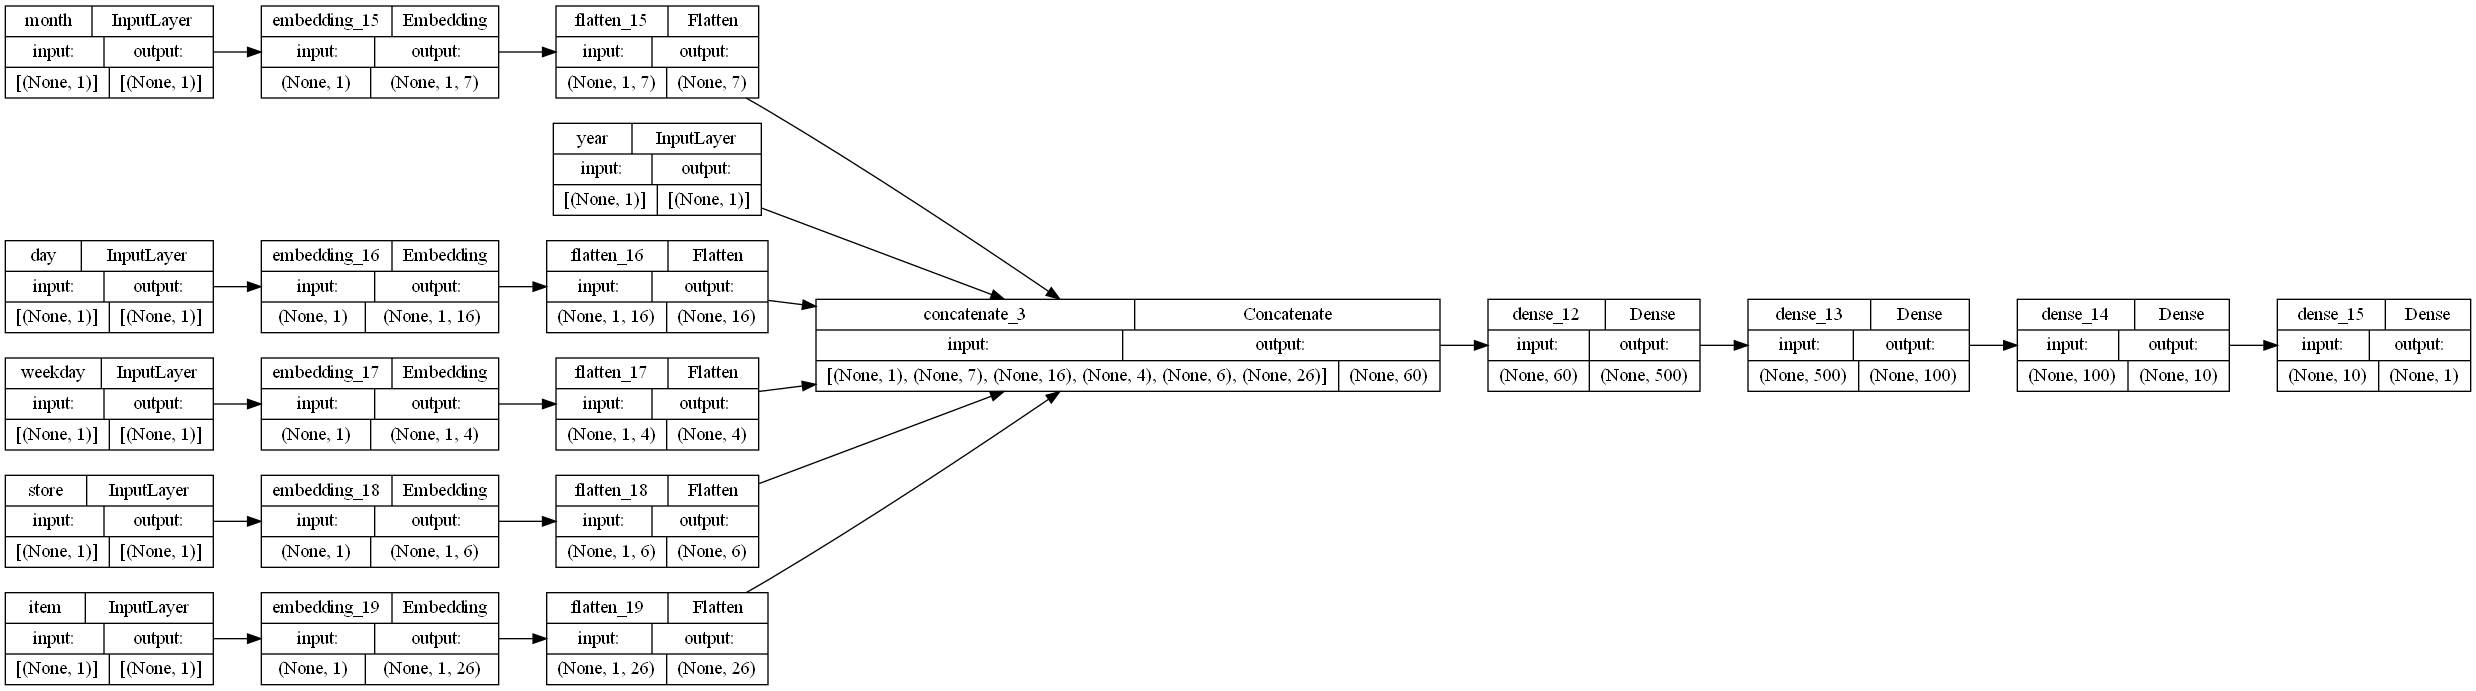

In [21]:
year = keras.Input(shape=(1,), name="year", dtype="float32")
month = keras.Input(shape=(1,), name="month", dtype="int64")
day = keras.Input(shape=(1,), name="day", dtype="int64")
weekday = keras.Input(shape=(1,), name="weekday", dtype="int64")
store = keras.Input(shape=(1,), name="store", dtype="int64")
item = keras.Input(shape=(1,), name="item", dtype="int64")

all_inputs = [
    year,
    month,
    day,
    weekday,
    store,
    item
]

m = layers.Embedding(unique['month']+1, (unique['month']//2)+1)(month)
outputm = layers.Flatten()(m)
d = layers.Embedding(unique['day']+1, (unique['day']//2)+1)(day)
outputd = layers.Flatten()(d)
wd = layers.Embedding(unique['weekday']+1, (unique['weekday']//2)+1)(weekday)
outputwd = layers.Flatten()(wd)
s = layers.Embedding(unique['store']+1, (unique['store']//2)+1)(store)
outputs = layers.Flatten()(s)
i = layers.Embedding(unique['item']+1, (unique['item']//2)+1)(item)
outputi = layers.Flatten()(i)

all_features = layers.concatenate([
    year,
    outputm,
    outputd,
    outputwd,
    outputs,
    outputi,
])
x = layers.Dense(500, activation="relu")(all_features)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(10, activation="relu")(x)
output = layers.Dense(1, activation="linear")(x)
modelv = keras.Model(all_inputs, output)
keras.utils.plot_model(modelv, show_shapes=True, rankdir="LR")